In [26]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [27]:
# Load data
OE_detailed = pd.read_parquet(Path("../data/processed/oe_detailed.parquet")) 
product_pick_times = pd.read_csv(Path("../data/processed/product_pick_times.csv"))
display(OE_detailed.head(3))

,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID,Prev_Timestamp,Prev_LocationID,...,Prev_Bay,Prev_Level,Prev_Slot,Aisle2,Bay2,Prev_Aisle2,Prev_Bay2,LocKey,PrevLocKey,Distance
0,PickPut,64,20,7955278,3250,1,2025-11-10 12:23:59.540,34343,NaT,<NA>,...,<NA>,<NA>,<NA>,42,12,<NA>,<NA>,42|12|||,<NA>|<NA>|||,NaN
1,PickPut,64,20,7955281,43178,1,2025-11-10 12:26:23.993,14453,2025-11-10 12:23:59.540,34343,...,12,6,7,34,26,42,12,34|26|||,42|12|||,220.0
2,PickPut,64,20,7955279,5842,1,2025-11-10 12:28:31.110,23294,2025-11-10 12:26:23.993,14453,...,26,6,1,42,05,34,26,42|05|||,34|26|||,514.0


In [28]:
df = OE_detailed.copy()

df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df = df.dropna(subset=["Timestamp"]).copy()

df = df[
    (df["Distance"] > 0) &
    (df["Time_Delta_sec"] > 0) &
    df["Weight"].notna() &
    df["Cube"].notna()
].copy()

df["log_time"] = np.log(df["Time_Delta_sec"])
df["log_distance"] = np.log(df["Distance"])
df["log_weight"] = np.log(df["Weight"])
df["log_cube"] = np.log(df["Cube"])

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [29]:
# Signed level change
df["Level"] = pd.to_numeric(df["Level"], errors="coerce")
df["Prev_Level"] = pd.to_numeric(df["Prev_Level"], errors="coerce")

df["level_change"] = df["Level"] - df["Prev_Level"]

In [30]:
# Hour of day
df["hour"] = df["Timestamp"].dt.hour

# Bucketed time of day (categorical)
def tod_bucket(h):
    if 6 <= h < 12:
        return "6-12"
    elif 12 <= h < 16:
        return "12-4"
    elif 16 <= h < 20:
        return "4-8"
    elif 20 <= h < 24:
        return "8-12"
    else:
        return "after_midnight"

df["time_of_day"] = df["hour"].apply(tod_bucket)

In [31]:
df = df.merge(
    product_pick_times[["ProductID", "avg_pick_time_sec"]],
    on="ProductID",
    how="left"
)

# Log-transform picktime where available
df["log_picktime"] = np.log(df["avg_pick_time_sec"])

In [32]:
model_df = df[[
    "Timestamp",
    "log_time",
    "log_distance",
    "log_weight",
    "log_cube",
    "WorkCode",
    "level_change",
    "time_of_day",
    "log_picktime"
]].copy()
model_df = model_df.dropna(subset=[
    "log_time",
    "log_distance",
    "log_weight",
    "log_cube",
    "WorkCode",
    "level_change",
    "time_of_day"
]).copy()

In [33]:
# Train-test split based on timestamp
split_date = pd.to_datetime("2025-11-23")

train = model_df[model_df["Timestamp"] < split_date].copy()
test  = model_df[model_df["Timestamp"] >= split_date].copy()

# Drop timestamp before modeling
train = train.drop(columns=["Timestamp"])
test  = test.drop(columns=["Timestamp"])

In [51]:
# naive model
# # Select only the variables for the simpler model
train_m = train[["log_time", "log_distance", "log_weight", "WorkCode"]].copy()
test_m  = test[ ["log_time", "log_distance", "log_weight", "WorkCode"]].copy()

# One-hot encode WorkCode
X_train = pd.get_dummies(train_m.drop(columns=["log_time"]), 
                         columns=["WorkCode"], 
                         drop_first=True)

X_test = pd.get_dummies(test_m.drop(columns=["log_time"]), 
                        columns=["WorkCode"], 
                        drop_first=True)

# Align test columns to train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_train = train_m["log_time"].astype(float)
y_test  = test_m["log_time"].astype(float)

# Replace inf and ensure float
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).astype(float)
X_test  = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).astype(float)

X_train_const = sm.add_constant(X_train, has_constant="add")

model = sm.OLS(y_train, X_train_const).fit(method="qr")

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               log_time   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     2966.
Date:                Mon, 09 Feb 2026   Prob (F-statistic):               0.00
Time:                        16:40:14   Log-Likelihood:                -45187.
No. Observations:               37113   AIC:                         9.038e+04
Df Residuals:                   37108   BIC:                         9.043e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.3718      0.028     84.282   

In [54]:
X_test_const = sm.add_constant(X_test, has_constant="add")

pred = model.predict(X_test_const)

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("Test RMSE (log scale):", rmse)
print("Test R^2:", r2)

coef_table = pd.DataFrame({
    "variable": model.params.index,
    "coefficient": model.params.values,
    "p_value": model.pvalues.values
})
print(coef_table)

Test RMSE (log scale): 0.8227787407639435
Test R^2: 0.2490820936688305
       variable  coefficient       p_value
0         const     2.371828  0.000000e+00
1  log_distance     0.384765  0.000000e+00
2    log_weight     0.010528  2.059615e-04
3   WorkCode_20    -0.106186  9.241390e-10
4   WorkCode_30     0.245632  4.155697e-40


In [ ]:
# Extended model with picktime
train_m = train[["log_time","log_distance","log_weight","log_cube","WorkCode","log_picktime"]].copy()
test_m  = test[ ["log_time","log_distance","log_weight","log_cube","WorkCode","log_picktime"]].copy()

# ---- handle missing picktime (keep rows) ----
train_m["has_picktime"] = train_m["log_picktime"].notna().astype(int)
test_m["has_picktime"]  = test_m["log_picktime"].notna().astype(int)
train_m["log_picktime"] = train_m["log_picktime"].fillna(0)
test_m["log_picktime"]  = test_m["log_picktime"].fillna(0)

# ---- dummies + align ----
X_train = pd.get_dummies(train_m.drop(columns=["log_time"]), columns=["WorkCode"], drop_first=True)
X_test  = pd.get_dummies(test_m.drop(columns=["log_time"]),  columns=["WorkCode"], drop_first=True)
X_test  = X_test.reindex(columns=X_train.columns, fill_value=0)

y_train = train_m["log_time"].astype(float)

# ---- harden numerics (prevents object/SVD issues) ----
X_train = X_train.replace([np.inf, -np.inf], np.nan).apply(pd.to_numeric, errors="coerce").fillna(0).astype(float)
y_train = pd.to_numeric(y_train, errors="coerce").fillna(0).astype(float)

# drop zero-variance columns (helps stability)
zero_var = X_train.columns[X_train.nunique() <= 1]
X_train = X_train.drop(columns=zero_var)
X_test  = X_test.drop(columns=zero_var).astype(float)

# Build named design matrices (keep column names)
X_train_const = sm.add_constant(X_train, has_constant="add")
X_test_const  = sm.add_constant(X_test,  has_constant="add")

# IMPORTANT: pass DataFrame/Series (not .to_numpy()) so names are preserved
model = sm.OLS(y_train.astype(float), X_train_const.astype(float)).fit(method="qr")

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               log_time   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     1757.
Date:                Mon, 09 Feb 2026   Prob (F-statistic):               0.00
Time:                        16:37:21   Log-Likelihood:                -45023.
No. Observations:               37113   AIC:                         9.006e+04
Df Residuals:                   37105   BIC:                         9.013e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2940      0.030     76.109   

In [50]:
coef_table = pd.DataFrame({
    "coefficient": model.params,
    "p_value": model.pvalues
}).round(4)

print(coef_table)

              coefficient  p_value
const              2.2940   0.0000
log_distance       0.3940   0.0000
log_weight         0.0175   0.0000
log_cube          -0.0090   0.0162
log_picktime       0.0599   0.0000
has_picktime      -0.0124   0.3112
WorkCode_20       -0.0545   0.0049
WorkCode_30        0.1781   0.0000


In [42]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

# y_test
y_test = pd.to_numeric(test_m["log_time"], errors="coerce")

# clean X_test once + add constant once
X_test_clean = (
    X_test.replace([np.inf, -np.inf], np.nan)
          .apply(pd.to_numeric, errors="coerce")
          .fillna(0)
          .astype(float)
)

X_test_const = sm.add_constant(X_test_clean, has_constant="add")

# predict (model was fit using numpy arrays, so use numpy here too)
pred = model.predict(X_test_const.to_numpy())

# align + drop NaNs for metrics
pred = pd.Series(pred, index=y_test.index)
mask = y_test.notna() & pred.notna()

rmse = np.sqrt(mean_squared_error(y_test.loc[mask], pred.loc[mask]))
r2 = r2_score(y_test.loc[mask], pred.loc[mask])

print("Test RMSE (log scale):", rmse)
print("Test R^2:", r2)

Test RMSE (log scale): 0.820263641121719
Test R^2: 0.25366594262589237


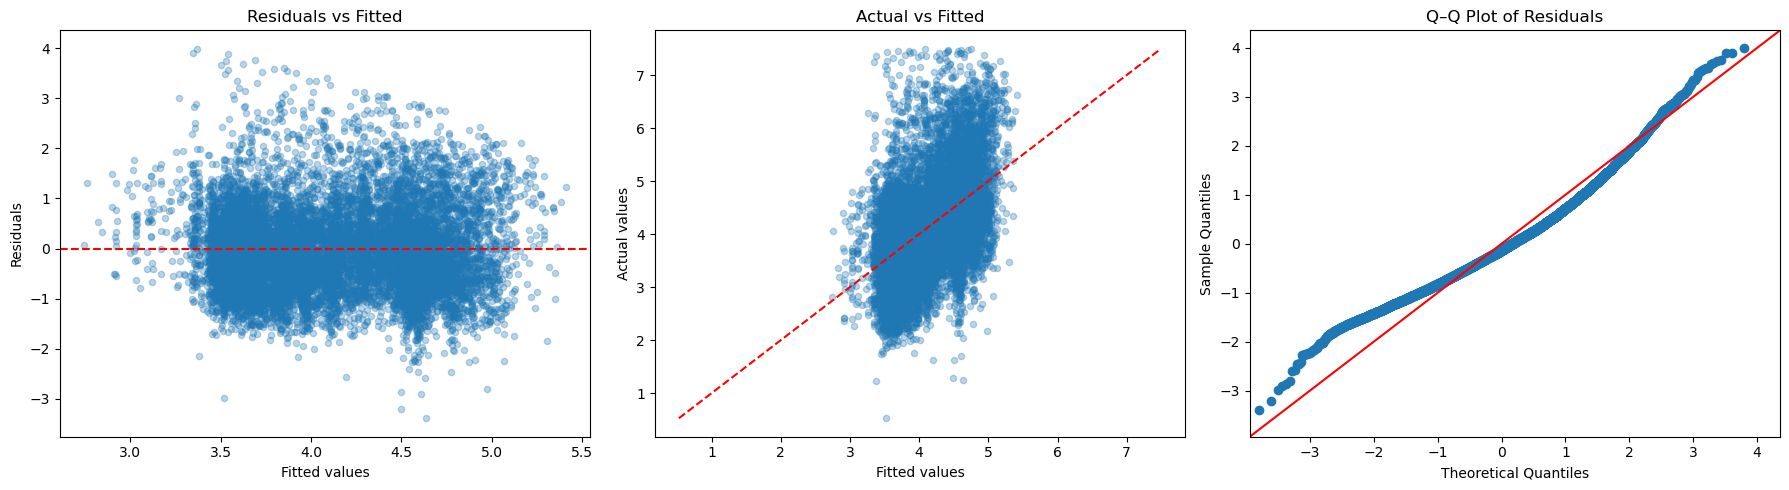

In [43]:
fitted = pred
actual = y_test
resid = actual - fitted

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---- 1) Residuals vs Fitted ----
axes[0].scatter(fitted, resid, alpha=0.3, s=20)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title("Residuals vs Fitted")
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")

# ---- 2) Actual vs Fitted ----
axes[1].scatter(fitted, actual, alpha=0.3, s=20)
lims = [
    np.min([fitted.min(), actual.min()]),
    np.max([fitted.max(), actual.max()])
]
axes[1].plot(lims, lims, 'r--')
axes[1].set_title("Actual vs Fitted")
axes[1].set_xlabel("Fitted values")
axes[1].set_ylabel("Actual values")

# ---- 3) Q–Q Plot ----
sm.qqplot(resid, line='45', ax=axes[2])
axes[2].set_title("Q–Q Plot of Residuals")

plt.tight_layout()
plt.show()